In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Extract zip folder

import zipfile

zip_path = '/content/drive/MyDrive/PlantVillageMini.zip'  # Zip file for the plant village dataset
extract_path = '/content/drive/MyDrive/datasets'  # location of unzip

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os

address="/content/drive/MyDrive/datasets/PlantVillageMini"

# List files
print(os.listdir(address))
num_classes=len(os.listdir(address))
print(num_classes)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']
5


In [ ]:
#Count number of images

import os

address='/content/drive/MyDrive/datasets/PlantVillageMini'

#List Files
print(os.listdir(address))
num_classes=len(os.listdir(address))
print(num_classes)

count=0
for i in os.listdir(address):
  for j in os.listdir(os.path.join(address,i)):
    count+=1

print("Number of images:",count)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']
5
Number of images: 4627


In [ ]:
#Creating dataset
import os
import numpy as np
from sklearn.model_selection import train_test_split

data_dir = address  # Root folder with class subfolders
class_names = os.listdir(data_dir)  # ['class1', 'class2', ...]
num_classes=len(class_names)

# Collect file paths and labels
file_paths = []
labels = []

for class_id, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for file in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, file))
        labels.append(class_id)  # Assign numerical label (0, 1, 2, ...)

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)

# Split into 80% train, 20% test (adjust ratio as needed)
X_train, X_test, y_train, y_test = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42
)

from tensorflow.keras.utils import to_categorical
#one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(X_test.shape)
print(y_test.shape)

(926,)
(926, 5)


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

input_size=[224,224]

def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, input_size)  # Resize for your model
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)  #batches of 32, with prefetch optimization for faster loading
test_dataset = test_dataset.map(preprocess_image).batch(32)

In [ ]:
#Define the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

model = Sequential([
    # Input Layer (250x250 RGB images)
    Conv2D(32, (3, 3), activation='relu', input_shape=(input_size[0], input_size[1], 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    BatchNormalization(),


    # Fully Connected Layers
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Reduces overfitting
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output Layer (Softmax for multi-class classification)
    Dense(num_classes, activation='softmax')  # Replace `num_classes` with your class count
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()
import tensorflow as tf

print("Num GPU Available: ",len(tf.config.list_physical_devices('GPU')))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,477 (630.77 KB)

 Trainable params: 160,645 (627.52 KB)

 Non-trainable params: 832 (3.25 KB)

Num GPU Available:  0


In [ ]:
#Compile and train
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')  #Stop training early if accuracy starts to reduce

reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS=10

model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS, callbacks=[early_stop, reduce_lr])

Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 704s 6s/step - accuracy: 0.6571 - loss: 0.9018 - val_accuracy: 0.2322 - val_loss: 2.8926 - learning_rate: 0.0010
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 747s 6s/step - accuracy: 0.8889 - loss: 0.3507 - val_accuracy: 0.2333 - val_loss: 3.2258 - learning_rate: 0.0010
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 736s 6s/step - accuracy: 0.9323 - loss: 0.2229 - val_accuracy: 0.3229 - val_loss: 2.5758 - learning_rate: 0.0010
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 734s 6s/step - accuracy: 0.9387 - loss: 0.1801 - val_accuracy: 0.7419 - val_loss: 0.9145 - learning_rate: 0.0010
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 735s 6s/step - accuracy: 0.9496 - loss: 0.1566 - val_accuracy: 0.6317 - val_loss: 1.9574 - learning_rate: 0.0010
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9530 - loss: 0.1333
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
116/116 ━━━━━━━━━━━━━━━━━━━━ 737s 6s/step - accuracy: 0.9530 - loss: 0.133

In [ ]:
model.save("LeafClassifier_scratch1.keras")

In [ ]:
from google.colab import files
files.download('LeafClassifier_scratch1.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9475 - loss: 0.1680
Test Loss: 0.18288108706474304
Test Accuracy: 94.28%


In [ ]:
#Making Predictions
import matplotlib.pyplot as plt

for images, labels in test_dataset.take(1):
    # images.shape => (batch_size, height, width, channels)
    # labels.shape => (batch_size,)

    # 2. Take first 5 images
    five_images = images[:5]
    five_labels = labels[:5]
    break  # Only need one batch

predictions = model.predict(five_images)
predicted_classes = tf.argmax(predictions, axis=1)

print("Predicted classes:", predicted_classes.numpy())
print("True labels:", five_labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
Predicted classes: [2 1 1 2 1]
True labels: [[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


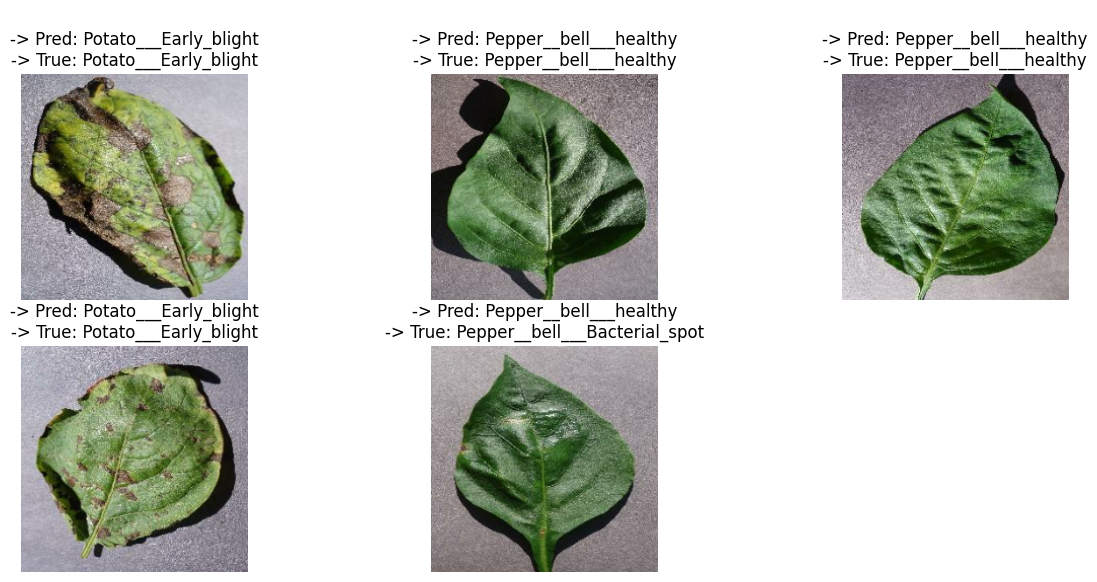

In [ ]:
import matplotlib.pyplot as plt

class_names = os.listdir(data_dir)

plt.figure(figsize=(15,10))
for i in range(5):
    plt.subplot(3,3,i+1)
    plt.imshow(five_images[i])
    plt.title("\n-> Pred: "+class_names[predicted_classes[i]]+"\n-> True: "+class_names[np.argmax(five_labels[i])])
    plt.axis('off')
plt.show()